# Debug training

In [44]:
# Imports

import os, logging, argparse, sys

import torch

from hyformer.configs.dataset import DatasetConfig
from hyformer.configs.tokenizer import TokenizerConfig
from hyformer.configs.model import ModelConfig
from hyformer.configs.trainer import TrainerConfig

from hyformer.utils.datasets.auto import AutoDataset
from hyformer.utils.tokenizers.auto import AutoTokenizer
from hyformer.models.auto import AutoModel

from hyformer.trainers.trainer import Trainer

from hyformer.utils.reproducibility import set_seed

# autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
DATA_DIR = "/lustre/groups/aih/hyformer/data"

DATASET_CONFIG_PATH = "configs/datasets/guacamol/config.json"
TOKENIZER_CONFIG_PATH = "configs/tokenizers/smiles/guacamol/config.json"
MODEL_CONFIG_PATH = "configs/models/guacamol/hyformer_small/config.json"
TRAINER_CONFIG_PATH = "configs/trainers/distribution_learning/guacamol/lm/config.json"


In [64]:
# Load configurations
dataset_config = DatasetConfig.from_config_filepath(DATASET_CONFIG_PATH)
tokenizer_config = TokenizerConfig.from_config_filepath(TOKENIZER_CONFIG_PATH)
model_config = ModelConfig.from_config_filepath(MODEL_CONFIG_PATH)
trainer_config = TrainerConfig.from_config_filepath(TRAINER_CONFIG_PATH)


In [65]:
# if we do prediction, we need to set the task to prediction
model_config.num_prediction_tasks = 200
prediction_task_type = "regression"


In [66]:
# Initialize
train_dataset = AutoDataset.from_config(dataset_config, split='train', root=DATA_DIR)
val_dataset = AutoDataset.from_config(dataset_config, split='val', root=DATA_DIR)


In [67]:
tokenizer = AutoTokenizer.from_config(tokenizer_config)


In [68]:
# Determine the device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


In [72]:

model = AutoModel.from_config(model_config, num_prediction_tasks=200, prediction_task_type="regression")
model.to(device)


Hyformer(
  (token_embedding): Embedding(109, 256)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (attention_layer): Attention(
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (k_proj): Linear(in_features=256, out_features=256, bias=False)
        (v_proj): Linear(in_features=256, out_features=256, bias=False)
        (out): Linear(in_features=256, out_features=256, bias=False)
        (relative_embedding): RotaryEmbedding()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w3): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_layer_normalization): RMSNorm()
      (feed_forward_normalization): RMSNorm()
    )
  )
  (layer_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=109, bias=False)
  (mlm_head): Linear(in_features=256, out_features=109, bias=False)

In [51]:
assert len(tokenizer) == model.vocab_size, f"Tokenizer vocab size {len(tokenizer)} does not match model embedding dim {model.embedding_dim}"

In [74]:
# Initialize trainer
trainer = Trainer(
    config=trainer_config,
    model=model,
    tokenizer=tokenizer,
    device=device,
    )



In [75]:
trainer_loader = trainer.create_loader(train_dataset, shuffle=True, tasks={'prediction': 1.0})

In [79]:
with torch.no_grad():
    batch = next(iter(trainer_loader))
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    output = model(**batch)
    

In [85]:
output['loss']

tensor(0.2357, device='cuda:0')

In [11]:
samples = [train_dataset[i]['data'] for i in range(2)]

In [12]:
samples


['CCC(C)(C)Br', 'CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O']

In [11]:
tokenizer(samples, task='lm')

{'input_ids': [[106, 102, 19, 19, 19, 4, 19, 5, 4, 19, 5, 18, 103],
  [106,
   102,
   19,
   19,
   19,
   23,
   4,
   19,
   19,
   97,
   7,
   97,
   97,
   97,
   97,
   4,
   6,
   97,
   8,
   97,
   97,
   97,
   97,
   97,
   8,
   5,
   97,
   7,
   5,
   19,
   4,
   16,
   24,
   5,
   19,
   7,
   24,
   19,
   4,
   19,
   4,
   16,
   24,
   5,
   24,
   5,
   16,
   19,
   19,
   4,
   23,
   5,
   19,
   7,
   23,
   19,
   4,
   19,
   5,
   16,
   24,
   103]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]]}

In [12]:
trainer_loader = trainer.create_loader(train_dataset, shuffle=True, tasks=trainer.config.tasks)

In [13]:
batch = next(iter(trainer_loader))

In [15]:
batch.keys()

dict_keys(['input_ids', 'task', 'attention_mask', 'input_labels', 'target'])

In [16]:
batch['input_ids']

tensor([[106, 102,  19,  ..., 104, 104, 104],
        [106, 102,  19,  ..., 104, 104, 104],
        [106, 102,  19,  ..., 104, 104, 104],
        ...,
        [106, 102,  24,  ..., 104, 104, 104],
        [106, 102,  97,  ..., 104, 104, 104],
        [106, 102,  24,  ..., 104, 104, 104]])

In [17]:
batch['task']

'lm'

In [18]:
batch['attention_mask']


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [19]:
batch['input_labels']

tensor([[-100, -100,   19,  ..., -100, -100, -100],
        [-100, -100,   19,  ..., -100, -100, -100],
        [-100, -100,   19,  ..., -100, -100, -100],
        ...,
        [-100, -100,   24,  ..., -100, -100, -100],
        [-100, -100,   97,  ..., -100, -100, -100],
        [-100, -100,   24,  ..., -100, -100, -100]])

In [20]:
batch['target']

In [21]:
batch['input_ids'].shape

torch.Size([1024, 128])

In [25]:
batch['input_ids'][0] == 103

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

In [26]:
batch['attention_mask'][0][batch['input_ids'][0] == 103]

tensor([1])

In [29]:
batch['input_labels'].shape

torch.Size([1024, 128])

In [30]:
model

Hyformer(
  (token_embedding): Embedding(511, 256)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (attention_layer): Attention(
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (k_proj): Linear(in_features=256, out_features=256, bias=False)
        (v_proj): Linear(in_features=256, out_features=256, bias=False)
        (out): Linear(in_features=256, out_features=256, bias=False)
        (relative_embedding): RotaryEmbedding()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w3): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_layer_normalization): RMSNorm()
      (feed_forward_normalization): RMSNorm()
    )
  )
  (layer_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=511, bias=False)
  (mlm_head): Linear(in_features=256, out_features=511, bias=False)

In [31]:
len(tokenizer)

109

In [32]:
tokenizer.vocab

{'#': 0,
 '%10': 1,
 '%11': 2,
 '%12': 3,
 '(': 4,
 ')': 5,
 '-': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15,
 '=': 16,
 'B': 17,
 'Br': 18,
 'C': 19,
 'Cl': 20,
 'F': 21,
 'I': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'S': 26,
 '[B-]': 27,
 '[BH-]': 28,
 '[BH2-]': 29,
 '[BH3-]': 30,
 '[B]': 31,
 '[Br+2]': 32,
 '[Br-]': 33,
 '[C+]': 34,
 '[C-]': 35,
 '[CH+]': 36,
 '[CH-]': 37,
 '[CH2+]': 38,
 '[CH2]': 39,
 '[CH]': 40,
 '[Cl+2]': 41,
 '[Cl+3]': 42,
 '[Cl+]': 43,
 '[Cl-]': 44,
 '[F+]': 45,
 '[F-]': 46,
 '[H]': 47,
 '[I+2]': 48,
 '[I+3]': 49,
 '[I+]': 50,
 '[I-]': 51,
 '[IH2]': 52,
 '[N+]': 53,
 '[N-]': 54,
 '[NH+]': 55,
 '[NH-]': 56,
 '[NH2+]': 57,
 '[NH3+]': 58,
 '[N]': 59,
 '[O+]': 60,
 '[O-]': 61,
 '[OH+]': 62,
 '[O]': 63,
 '[P+]': 64,
 '[P-]': 65,
 '[PH2+]': 66,
 '[PH]': 67,
 '[S+]': 68,
 '[S-]': 69,
 '[SH+]': 70,
 '[SH-]': 71,
 '[SH]': 72,
 '[Se+]': 73,
 '[Se-]': 74,
 '[SeH2]': 75,
 '[SeH]': 76,
 '[Se]': 77,
 '[Si-]': 78,
 '[SiH-]': 79,
 '[SiH

In [40]:
from tqdm.auto import tqdm


for idx in tqdm(range(len(train_dataset))):
    sample = train_dataset[idx]
    input_ids = tokenizer(sample['data'], task='lm')['input_ids']
    sample_tokens = tokenizer.decode(torch.tensor(input_ids).reshape(1, -1))
    if sample['data'] != sample_tokens:
        print(f"Mismatch at index {idx}")
        print(f"Original: {sample['data']}")
        print(f"Decoded: {sample_tokens}")
        

  0%|          | 0/1273104 [00:00<?, ?it/s]

In [30]:
with torch.no_grad():
    batch = next(iter(trainer_loader))
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    output = model(**batch)
    

RMSNorm input: dtype=torch.float32, shape=torch.Size([1024, 128, 256])
Epsilon: 1e-06
After float conversion: dtype=torch.float32
After norm: dtype=torch.float32, contains NaN=False
After type_as: dtype=torch.float32
Final output: dtype=torch.float32
RMSNorm input: dtype=torch.float32, shape=torch.Size([1024, 128, 256])
Epsilon: 1e-06
After float conversion: dtype=torch.float32
After norm: dtype=torch.float32, contains NaN=False
After type_as: dtype=torch.float32
Final output: dtype=torch.float32
RMSNorm input: dtype=torch.float32, shape=torch.Size([1024, 128, 256])
Epsilon: 1e-06
After float conversion: dtype=torch.float32
After norm: dtype=torch.float32, contains NaN=False
After type_as: dtype=torch.float32
Final output: dtype=torch.float32
RMSNorm input: dtype=torch.float32, shape=torch.Size([1024, 128, 256])
Epsilon: 1e-06
After float conversion: dtype=torch.float32
After norm: dtype=torch.float32, contains NaN=False
After type_as: dtype=torch.float32
Final output: dtype=torch.floa

In [14]:
trainer_loader = trainer.create_loader(train_dataset, shuffle=True, tasks=trainer.config.tasks)
batch = next(iter(trainer_loader))
batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
output = model(**batch)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'

In [31]:
output

{'embeddings': tensor([[[ 0.4813,  0.4716, -0.0284,  ...,  1.9936, -0.9211,  0.8080],
          [ 0.1341,  0.4819,  0.7443,  ...,  2.5249, -0.2914,  0.8500],
          [ 0.4777,  1.0220,  1.1169,  ...,  1.5697, -0.4688,  0.7853],
          ...,
          [ 0.9571,  0.1316,  0.2807,  ..., -2.0248,  0.6369,  0.0666],
          [ 0.8692,  0.1617,  0.2442,  ..., -2.0281,  0.6831,  0.0247],
          [ 0.8092,  0.2280,  0.2257,  ..., -2.0261,  0.6963, -0.0322]],
 
         [[ 0.4813,  0.4716, -0.0284,  ...,  1.9936, -0.9211,  0.8080],
          [ 0.1341,  0.4819,  0.7443,  ...,  2.5249, -0.2914,  0.8500],
          [ 0.4777,  1.0220,  1.1169,  ...,  1.5697, -0.4688,  0.7853],
          ...,
          [-0.8919, -0.8109, -0.2490,  ...,  1.2396, -0.8445,  0.0707],
          [-0.9101, -0.7516, -0.2737,  ...,  1.3754, -0.8288,  0.0614],
          [-0.8724, -0.7493, -0.2219,  ...,  1.4644, -0.7920,  0.0825]],
 
         [[ 0.4813,  0.4716, -0.0284,  ...,  1.9936, -0.9211,  0.8080],
          [ 0.

In [16]:
len(tokenizer)

109

In [17]:
model.vocab_size

109

In [ ]:
  # Use a minimal batch with a single short sequence
   simple_input = {"input_ids": torch.tensor([[1, 2, 3]]).to(device), 
                   "attention_mask": torch.tensor([[1, 1, 1]]).to(device),
                   "task": "lm"}

In [94]:
import pandas as pd

from hyformer.utils.datasets.sequence import SequenceDataset

In [95]:
# Load peptide dataset

data_filepath = "/lustre/groups/aih/hyformer/data_proprietary/peptides/mic/raw/mic_data.csv"

_df = pd.read_csv(data_filepath, index_col=0)
data = _df['sequence']
target = _df['value']

dataset = SequenceDataset(data=data, target=target)


In [96]:
dataset[0]

{'data': 'AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS', 'target': 2.099950350098421}

In [101]:
TOKENIZER_CONFIG_PATH = "configs/tokenizers/amino_acid/config.json"

tokenizer_config = TokenizerConfig.from_config_filepath(TOKENIZER_CONFIG_PATH)
tokenizer = AutoTokenizer.from_config(tokenizer_config)

In [104]:
from tqdm.auto import tqdm


for idx in tqdm(range(len(dataset))):
    sample = dataset[idx]
    input_ids = tokenizer(sample['data'], task='lm')['input_ids']
    sample_tokens = tokenizer.decode(torch.tensor(input_ids).reshape(1, -1))
    if sample['data'] != sample_tokens:
        print(f"Mismatch at index {idx}")
        print(f"Original: {sample['data']}")
        print(f"Decoded: {sample_tokens}")
        

  0%|          | 0/4546 [00:00<?, ?it/s]

{'data': 'YWRWRW', 'target': 1.278935990813498}

In [110]:
# =========== RoPE Implementation Test (Fixed Device Issue) ===========
# Tests if your RoPE implementation properly handles float32 conversion

import torch
import numpy as np
import matplotlib.pyplot as plt
from hyformer.models.layers.rotary import RotaryEmbedding, apply_rotary_emb

def test_rope_implementation():
    """Test if RoPE handles float32 computation correctly across different dtypes."""
    print("Testing RoPE Implementation...\n")
    
    # Test parameters
    head_dim = 64
    seq_len = 256
    batch_size = 2
    
    # Device detection
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize RoPE with your implementation's signature
    rope = RotaryEmbedding(dim=head_dim).to(device)  # Move to correct device
    
    # Test across multiple dtypes
    dtypes = [torch.float32]
    if device.type == 'cuda':
        dtypes.append(torch.float16)
        if torch.cuda.is_bf16_supported():
            dtypes.append(torch.bfloat16)
    
    results = {}
    
    for dtype in dtypes:
        print(f"\n--- Testing with dtype: {dtype} ---")
        
        # Create query and key tensors
        q = torch.randn(batch_size, seq_len, head_dim, device=device, dtype=dtype)
        k = torch.randn(batch_size, seq_len, head_dim, device=device, dtype=dtype)
        
        # Save original values for comparison
        q_orig = q.clone()
        k_orig = k.clone()
        
        # Generate position sequence - MAKE SURE IT'S ON THE SAME DEVICE
        position_ids = torch.arange(seq_len, device=device, dtype=torch.float32)
        
        # Measure time and check for NaNs
        with torch.no_grad():
            start_time = torch.cuda.Event(enable_timing=True) if device.type == 'cuda' else None
            end_time = torch.cuda.Event(enable_timing=True) if device.type == 'cuda' else None
            
            if device.type == 'cuda':
                start_time.record()
            
            try:
                # Debug info
                print(f"  position_ids.device = {position_ids.device}, rope.device = {next(rope.parameters()).device}")
                
                # Get RoPE embeddings - using your API
                freqs = rope(position_ids, seq_len=seq_len)
                
                # Check freq dtype
                print(f"  freqs.dtype = {freqs.dtype}")
                
                # Force float32 computation check
                print(f"  Using autocast? {'Yes' if hasattr(apply_rotary_emb, '__wrapped__') else 'No'}")
                
                # Apply RoPE to q and k
                q_rope = apply_rotary_emb(freqs, q)
                k_rope = apply_rotary_emb(freqs, k)
                
                if device.type == 'cuda':
                    end_time.record()
                    torch.cuda.synchronize()
                    elapsed_time = start_time.elapsed_time(end_time)
                    print(f"  Time elapsed: {elapsed_time:.2f} ms")
                
                # Check for NaNs
                q_has_nan = torch.isnan(q_rope).any().item()
                k_has_nan = torch.isnan(k_rope).any().item()
                print(f"  Contains NaN values: q={q_has_nan}, k={k_has_nan}")
                
                # Check dtype consistency
                print(f"  Output dtype: q_rope={q_rope.dtype}, k_rope={k_rope.dtype}")
                print(f"  Input dtype: q={q.dtype}, k={k.dtype}")
                print(f"  Dtype preserved: q={q.dtype == q_rope.dtype}, k={k.dtype == k_rope.dtype}")
                
                # Check value ranges
                print(f"  q_rope range: [{q_rope.min().item():.6f}, {q_rope.max().item():.6f}]")
                print(f"  k_rope range: [{k_rope.min().item():.6f}, {k_rope.max().item():.6f}]")
                
                # Check if output shapes match input shapes
                print(f"  Shape preserved: q={q.shape == q_rope.shape}, k={k.shape == k_rope.shape}")
                
                # Calculate relative change
                q_diff = (q_rope - q_orig).abs().mean().item()
                k_diff = (k_rope - k_orig).abs().mean().item()
                print(f"  Mean absolute change: q={q_diff:.6f}, k={k_diff:.6f}")
                
                # Store results
                results[dtype] = {
                    'q_has_nan': q_has_nan,
                    'k_has_nan': k_has_nan,
                    'q_diff': q_diff,
                    'k_diff': k_diff,
                    'q_rope': q_rope.detach().cpu().float().numpy(),
                    'dtype_match': q.dtype == q_rope.dtype
                }
            
            except Exception as e:
                print(f"  Error during testing: {str(e)}")
                results[dtype] = {
                    'q_has_nan': True,
                    'k_has_nan': True,
                    'q_diff': 0,
                    'k_diff': 0,
                    'dtype_match': False,
                    'error': str(e)
                }
    
    # Check if we have any successful runs
    successful_runs = [dtype for dtype, res in results.items() if 'error' not in res]
    
    # Visualize and compare results across dtypes
    if len(successful_runs) > 1:
        plt.figure(figsize=(12, 6))
        for dtype in successful_runs:
            # Sample a small subset of values
            sample = results[dtype]['q_rope'][0, 0, :20]
            plt.plot(sample, label=f"{dtype}", alpha=0.7)
        
        plt.title("RoPE Output Comparison Across Dtypes")
        plt.legend()
        plt.show()
    
    # Final assessment
    print("\n=== Final Assessment ===")
    all_passing = True
    
    for dtype in dtypes:
        res = results[dtype]
        if 'error' in res:
            status = "✗ FAIL"
            all_passing = False
            print(f"{dtype}: {status} - Error: {res['error']}")
        else:
            passing = not res['q_has_nan'] and not res['k_has_nan'] and res['dtype_match']
            status = "✓ PASS" if passing else "✗ FAIL"
            all_passing = all_passing and passing
            
            issues = []
            if res['q_has_nan'] or res['k_has_nan']:
                issues.append("Contains NaN values")
            if not res['dtype_match']:
                issues.append("Output dtype doesn't match input")
            
            print(f"{dtype}: {status}" + (f" - Issues: {', '.join(issues)}" if issues else ""))
    
    overall = "✓ PASSED" if all_passing else "✗ FAILED"
    print(f"\nOverall RoPE Implementation Test: {overall}")
    
    # Check for float32 conversion in implementation
    print("\n=== Implementation Check ===")
    
    # Check if apply_rotary_emb has autocast decorator
    apply_has_autocast = hasattr(apply_rotary_emb, '__wrapped__')
    
    print(f"apply_rotary_emb has autocast decorator: {apply_has_autocast}")
    
    # Check for explicit casting in the code
    print("\nRecommendations:")
    print("1. Make sure apply_rotary_emb has @autocast('cuda', enabled=False) decorator")
    print("2. Ensure explicit .float() or to(torch.float32) conversions for trigonometric operations")
    print("3. Verify input dtype is preserved with .type_as() or .to(dtype) before returning")
    print("4. Check that all tensors are on the same device")


Testing RoPE Implementation...

Using device: cuda

--- Testing with dtype: torch.float32 ---
  position_ids.device = cuda:0, rope.device = cuda:0
  freqs.dtype = torch.float32
  Using autocast? Yes
  Time elapsed: 36.92 ms
  Contains NaN values: q=False, k=False
  Output dtype: q_rope=torch.float32, k_rope=torch.float32
  Input dtype: q=torch.float32, k=torch.float32
  Dtype preserved: q=True, k=True
  q_rope range: [-4.208825, 4.444884]
  k_rope range: [-3.612907, 3.952025]
  Shape preserved: q=True, k=True
  Mean absolute change: q=0.627384, k=0.628599

--- Testing with dtype: torch.float16 ---
  position_ids.device = cuda:0, rope.device = cuda:0
  freqs.dtype = torch.float32
  Using autocast? Yes
  Time elapsed: 3.68 ms
  Contains NaN values: q=False, k=False
  Output dtype: q_rope=torch.float16, k_rope=torch.float16
  Input dtype: q=torch.float16, k=torch.float16
  Dtype preserved: q=True, k=True
  q_rope range: [-4.535156, 4.113281]
  k_rope range: [-4.128906, 4.011719]
  Shape p

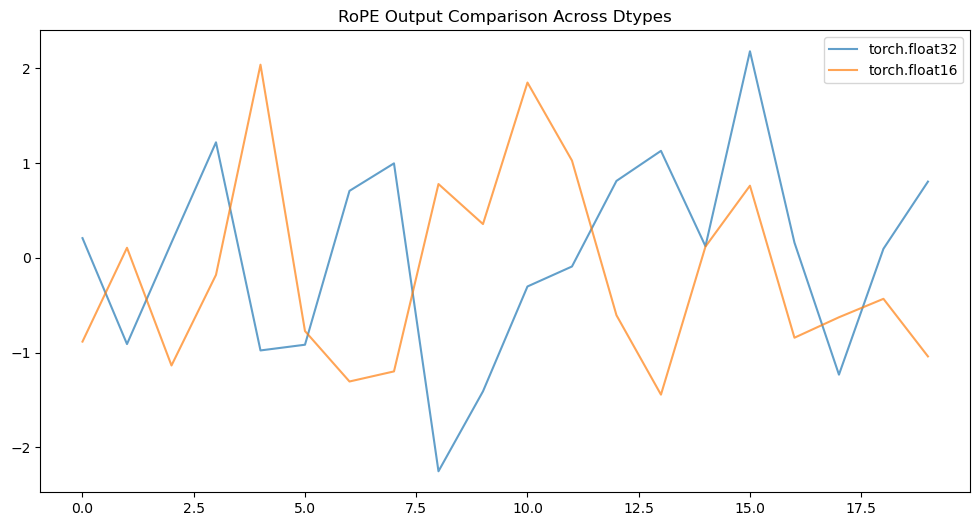


=== Final Assessment ===
torch.float32: ✓ PASS
torch.float16: ✓ PASS

Overall RoPE Implementation Test: ✓ PASSED

=== Implementation Check ===
apply_rotary_emb has autocast decorator: True

Recommendations:
1. Make sure apply_rotary_emb has @autocast('cuda', enabled=False) decorator
2. Ensure explicit .float() or to(torch.float32) conversions for trigonometric operations
3. Verify input dtype is preserved with .type_as() or .to(dtype) before returning
4. Check that all tensors are on the same device


In [111]:

test_rope_implementation()